In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

In [2]:
def parseData(df):
    """
    预处理数据
    """
    df['rentType'][df['rentType']=='--'] = '未知方式'
    # 转换object类型数据
    columns = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration', 'communityName', 'region', 'plate']
    for col in columns:
        df[col] = df[col].astype('category')
        
    # 将buildYear列转换为整型数据
    tmp = df['buildYear'].copy()
    tmp2 = tmp[tmp!='暂无信息'].astype('int')
    tmp[tmp=='暂无信息'] = tmp2.mode().iloc[0]
    df['buildYear'] = tmp
    df['buildYear'] = df['buildYear'].astype('int')
    
    # 处理pv和uv的空值
    df['pv'].fillna(df['pv'].mean(),inplace=True)
    df['uv'].fillna(df['uv'].mean(),inplace=True)
    df['pv'] = df['pv'].astype('int')
    df['uv'] = df['uv'].astype('int')
    
    # 去掉部分特征
 #   df.drop('communityName',axis=1, inplace=True)
    df.drop('city',axis=1,inplace=True)
    
    return df

In [3]:
def washData(df_train, df_test):
    """
    清洗数据
    """
   # tag = sorted(df_train['tradeMoney'])[-100]
    df_train = df_train[df_train['area']<=600]
    df_train = df_train[df_train['tradeMoney']<=70000]
    df_train = df_train[df_train['tradeMoney']>0]
#    df_train.drop('ID', axis=1, inplace=True)
#    df_test.drop('ID', axis=1,inplace=True)
    
    return df_train, df_test

In [4]:
def feature(df):
    """
    特征
    """
    # 将houseType转化为‘房间数’，‘厅数’，‘卫生间数’
    def parseRoom(info, index):
        res = int(info[index*2])
        return res
    df.insert(3,'room',None)
    df.insert(4, 'big_room', None)
    df.insert(5, 'wc', None)
    df['room'] = df['houseType'].apply(parseRoom, index=0)
    df['big_room'] = df['houseType'].apply(parseRoom, index=1)
    df['wc'] = df['houseType'].apply(parseRoom, index=2)
    df['trade_month'] = df['tradeTime'].apply(lambda x: int(x.split('/')[1]))
 #   df['trade_year'] = df['tradeTime'].apply(lambda x: int(x.split('/')[1]))
    df['pv_uv'] = df['pv'] / df['uv']
#     df['房间总数'] = df['室'] + df['厅'] + df['卫']
#    df['all_room'] = df['room']+df['big_room']+2*df['wc']
  #  df.drop('houseType', axis=1, inplace=True)
  #  df.drop('tradeTime', axis=1, inplace=True)
    
    categorical_feats = ['rentType','houseType', 'houseFloor', 'houseToward', 'houseDecoration', 'region', 'plate','communityName']
    return df, categorical_feats

In [5]:
train = pd.read_csv('data/train_data.csv')
test = pd.read_csv('data/test_a.csv')
train['trade_year'] = train['tradeTime'].apply(lambda x: int(x.split('/')[0]))

In [6]:
tmp = train.groupby(['region'])['plate'].agg('unique')

In [7]:
tmp = train.groupby(['communityName'])['plate'].agg('unique')

In [8]:
len(tmp),len(set(list(train['communityName'])))

(4236, 4236)

In [9]:
tmp = train.groupby(['plate'])['region'].agg('unique')
len(tmp),len(set(list(train['plate'])))

(66, 66)

In [10]:
tmp = train.groupby(['ID'])['communityName'].agg('unique')
len(tmp),len(set(list(train['ID'])))

(41440, 41440)

In [11]:
len(np.unique(train['communityName'].values)),len(np.unique(train['plate'].values)),len(np.unique(train['region'].values))

(4236, 66, 15)

In [12]:
test['trade_year'] = test['tradeTime'].apply(lambda x: int(x.split('/')[0]))

In [13]:
list(np.unique(train['tradeTime'])) and list(np.unique(test['tradeTime']))

['2018/1/11',
 '2018/1/12',
 '2018/1/15',
 '2018/1/16',
 '2018/1/2',
 '2018/1/21',
 '2018/1/23',
 '2018/1/24',
 '2018/1/26',
 '2018/1/27',
 '2018/1/28',
 '2018/1/29',
 '2018/1/30',
 '2018/1/31',
 '2018/1/5',
 '2018/1/7',
 '2018/10/1',
 '2018/10/10',
 '2018/10/11',
 '2018/10/12',
 '2018/10/13',
 '2018/10/14',
 '2018/10/15',
 '2018/10/16',
 '2018/10/17',
 '2018/10/18',
 '2018/10/19',
 '2018/10/20',
 '2018/10/21',
 '2018/10/22',
 '2018/10/24',
 '2018/10/25',
 '2018/10/27',
 '2018/10/28',
 '2018/10/29',
 '2018/10/30',
 '2018/10/31',
 '2018/10/6',
 '2018/10/7',
 '2018/10/8',
 '2018/10/9',
 '2018/11/1',
 '2018/11/10',
 '2018/11/11',
 '2018/11/12',
 '2018/11/13',
 '2018/11/14',
 '2018/11/15',
 '2018/11/16',
 '2018/11/17',
 '2018/11/18',
 '2018/11/19',
 '2018/11/2',
 '2018/11/20',
 '2018/11/21',
 '2018/11/22',
 '2018/11/23',
 '2018/11/24',
 '2018/11/25',
 '2018/11/26',
 '2018/11/27',
 '2018/11/28',
 '2018/11/29',
 '2018/11/3',
 '2018/11/30',
 '2018/11/4',
 '2018/11/5',
 '2018/11/6',
 '2018/11/

In [14]:
np.unique(test['tradeTime'])

array(['2018/1/11', '2018/1/12', '2018/1/15', '2018/1/16', '2018/1/2',
       '2018/1/21', '2018/1/23', '2018/1/24', '2018/1/26', '2018/1/27',
       '2018/1/28', '2018/1/29', '2018/1/30', '2018/1/31', '2018/1/5',
       '2018/1/7', '2018/10/1', '2018/10/10', '2018/10/11', '2018/10/12',
       '2018/10/13', '2018/10/14', '2018/10/15', '2018/10/16',
       '2018/10/17', '2018/10/18', '2018/10/19', '2018/10/20',
       '2018/10/21', '2018/10/22', '2018/10/24', '2018/10/25',
       '2018/10/27', '2018/10/28', '2018/10/29', '2018/10/30',
       '2018/10/31', '2018/10/6', '2018/10/7', '2018/10/8', '2018/10/9',
       '2018/11/1', '2018/11/10', '2018/11/11', '2018/11/12',
       '2018/11/13', '2018/11/14', '2018/11/15', '2018/11/16',
       '2018/11/17', '2018/11/18', '2018/11/19', '2018/11/2',
       '2018/11/20', '2018/11/21', '2018/11/22', '2018/11/23',
       '2018/11/24', '2018/11/25', '2018/11/26', '2018/11/27',
       '2018/11/28', '2018/11/29', '2018/11/3', '2018/11/30', '2018/11/4',

In [15]:
def getData(feature):
    """
    获取数据
    """
    train = pd.read_csv('data/train_data.csv')
    test = pd.read_csv('data/test_a.csv')
    
    train = parseData(train)
    test = parseData(test)
    train, test = washData(train, test)
    
    train, col = feature(train)
    test, col = feature(test)
    
    target = train.pop('tradeMoney')
    features = train.columns
    categorical_feats = col
    
    return train, test, target, features, categorical_feats

# 训练模型

In [16]:
train, test, target, features, categorical_feats = getData(feature)

/home/asus/.conda/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [17]:
train['tradeMoney']=target

In [18]:
train.columns

Index(['ID', 'area', 'rentType', 'room', 'big_room', 'wc', 'houseType',
       'houseFloor', 'totalFloor', 'houseToward', 'houseDecoration',
       'communityName', 'region', 'plate', 'buildYear', 'saleSecHouseNum',
       'subwayStationNum', 'busStationNum', 'interSchoolNum', 'schoolNum',
       'privateSchoolNum', 'hospitalNum', 'drugStoreNum', 'gymNum', 'bankNum',
       'shopNum', 'parkNum', 'mallNum', 'superMarketNum', 'totalTradeMoney',
       'totalTradeArea', 'tradeMeanPrice', 'tradeSecNum', 'totalNewTradeMoney',
       'totalNewTradeArea', 'tradeNewMeanPrice', 'tradeNewNum', 'remainNewNum',
       'supplyNewNum', 'supplyLandNum', 'supplyLandArea', 'tradeLandNum',
       'tradeLandArea', 'landTotalPrice', 'landMeanPrice', 'totalWorkers',
       'newWorkers', 'residentPopulation', 'pv', 'uv', 'lookNum', 'tradeTime',
       'trade_month', 'pv_uv', 'tradeMoney'],
      dtype='object')

In [19]:
features

Index(['ID', 'area', 'rentType', 'room', 'big_room', 'wc', 'houseType',
       'houseFloor', 'totalFloor', 'houseToward', 'houseDecoration',
       'communityName', 'region', 'plate', 'buildYear', 'saleSecHouseNum',
       'subwayStationNum', 'busStationNum', 'interSchoolNum', 'schoolNum',
       'privateSchoolNum', 'hospitalNum', 'drugStoreNum', 'gymNum', 'bankNum',
       'shopNum', 'parkNum', 'mallNum', 'superMarketNum', 'totalTradeMoney',
       'totalTradeArea', 'tradeMeanPrice', 'tradeSecNum', 'totalNewTradeMoney',
       'totalNewTradeArea', 'tradeNewMeanPrice', 'tradeNewNum', 'remainNewNum',
       'supplyNewNum', 'supplyLandNum', 'supplyLandArea', 'tradeLandNum',
       'tradeLandArea', 'landTotalPrice', 'landMeanPrice', 'totalWorkers',
       'newWorkers', 'residentPopulation', 'pv', 'uv', 'lookNum', 'tradeTime',
       'trade_month', 'pv_uv'],
      dtype='object')

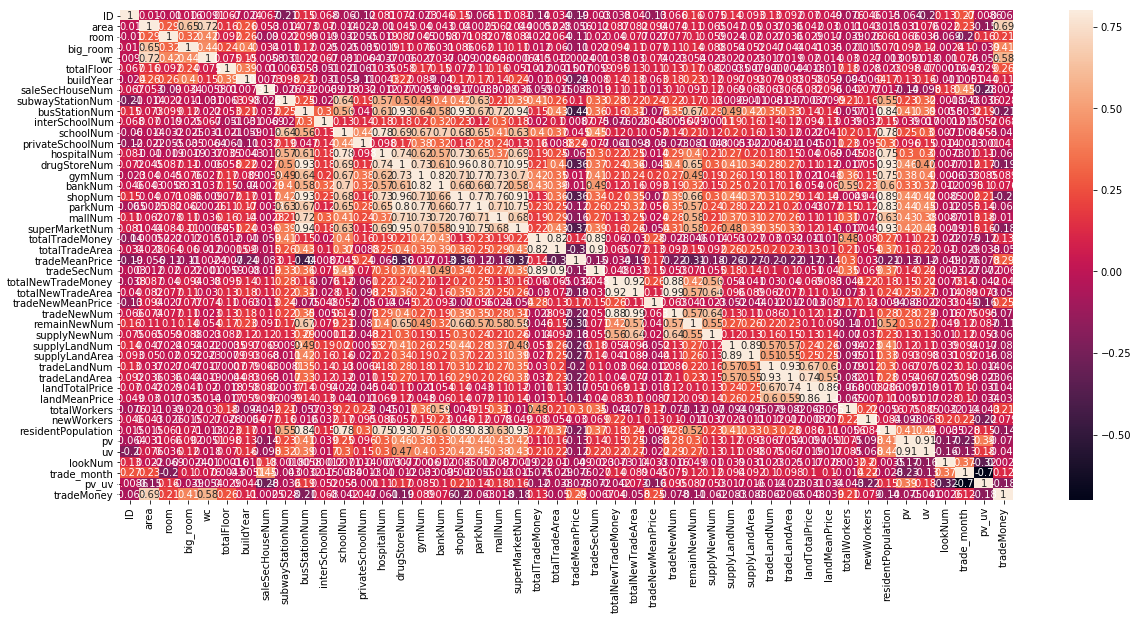

In [20]:
#correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns

corrmat = train.corr()
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corrmat, vmax=.8, annot=True);

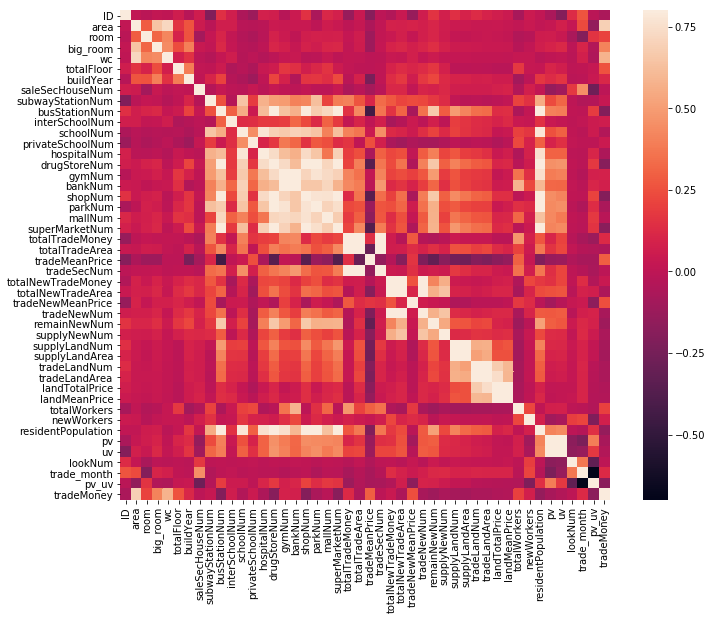

In [21]:
# Correlation matrix (heatmap style).
# correlation matri

corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True); 

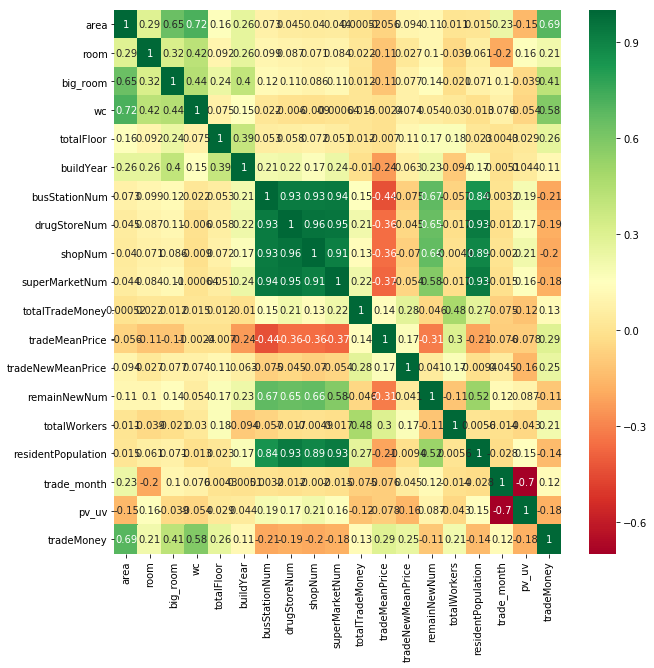

In [22]:
# most correlated features
corrmat = train.corr()
top_corr_features = corrmat.index[abs(corrmat['tradeMoney'])>0.1]
plt.figure(figsize=(10,10))
g = sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
train['source'] = 'train'
test['source'] = 'test'

In [25]:
all_data = pd.concat((train, test), axis = 0, ignore_index = True, sort = False)
for col in categorical_feats:
     all_data[col] = all_data[col].astype('category')

In [26]:
cols = [col for col in all_data.columns.values if 'Num' in col]
cols.append('communityName')
for col in cols:
    if col == 'communityName':
        tmp = all_data.groupby(['region']).agg({col:['count']})
    else:
        tmp = all_data.groupby(['region']).agg({col:['min','max','mean','sum','median']})
    tmp.columns=['region_communityName_'+'_'.join(ncol) for ncol in tmp.columns.values]
   
    tmp=tmp.reset_index()
   
    all_data = pd.merge(all_data,tmp,on=['region'],how='left')

In [27]:
community_fea = ['area','pv','uv','busStationNum','drugStoreNum', 'shopNum', 'superMarketNum',
       'totalTradeMoney', 'tradeMeanPrice', 'tradeNewMeanPrice',
       'remainNewNum', 'totalWorkers', 'residentPopulation']
for col in community_fea:
    tmp = all_data.groupby('communityName').agg({col:['min','max','mean','sum','median']})
    tmp.columns=['communityName_'+'_'.join(ncol) for ncol in tmp.columns.values]
   
    tmp=tmp.reset_index()
   
    all_data = pd.merge(all_data,tmp,on='communityName',how='left')

In [28]:
# community_fea = ['area','pv','uv','busStationNum','drugStoreNum', 'shopNum', 'superMarketNum',
#        'totalTradeMoney', 'tradeMeanPrice', 'tradeNewMeanPrice',
#        'remainNewNum', 'totalWorkers', 'residentPopulation']
# for col in community_fea:
#     tmp = all_data.groupby(['region','plate']).agg({col:['min','max','mean','sum','median']})
#     tmp.columns=['region_plate'+'_'.join(ncol) for ncol in tmp.columns.values]
#     tmp=tmp.reset_index()
  
#     all_data = pd.merge(all_data,tmp,on=['region','plate'],how='left')

In [29]:
# community_fea = ['area','pv','uv','busStationNum','drugStoreNum', 'shopNum', 'superMarketNum',
#        'totalTradeMoney', 'tradeMeanPrice', 'tradeNewMeanPrice',
#        'remainNewNum', 'totalWorkers', 'residentPopulation']
# for col in community_fea:
#     tmp = all_data.groupby(['plate']).agg({col:['min','max','mean','sum','median']})
#     tmp.columns=['plate'+'_'.join(ncol) for ncol in tmp.columns.values]
#     tmp=tmp.reset_index()
  
#     all_data = pd.merge(all_data,tmp,on=['plate'],how='left')

In [30]:
# community_fea = ['area','pv','uv','busStationNum','drugStoreNum', 'shopNum', 'superMarketNum',
#        'totalTradeMoney', 'tradeMeanPrice', 'tradeNewMeanPrice',
#        'remainNewNum', 'totalWorkers', 'residentPopulation']
# for col in community_fea:
#     tmp = all_data.groupby(['region']).agg({col:['min','max','mean','sum','median']})
#     tmp.columns=['region'+'_'.join(ncol) for ncol in tmp.columns.values]
#     tmp=tmp.reset_index()
  
#     all_data = pd.merge(all_data,tmp,on=['region'],how='left')

In [31]:
community_fea = ['area','pv','uv','busStationNum','drugStoreNum', 'shopNum', 'superMarketNum',
       'totalTradeMoney', 'tradeMeanPrice', 'tradeNewMeanPrice',
       'remainNewNum', 'totalWorkers', 'residentPopulation']
for col in community_fea:
    tmp = all_data.groupby(['communityName','houseType']).agg({col:['min','max','mean','sum','median']})
    tmp.columns=['communityName_houseType'+'_'.join(ncol) for ncol in tmp.columns.values]
    tmp=tmp.reset_index()
  
    all_data = pd.merge(all_data,tmp,on=['communityName','houseType'],how='left')

In [33]:
tmp = all_data.groupby(['communityName']).agg({'tradeTime':['count']})
tmp.columns=['communityName_tradeTime'+'_'.join(ncol) for ncol in tmp.columns.values]
tmp=tmp.reset_index()

all_data = pd.merge(all_data,tmp,on=['communityName'],how='left')

In [34]:
tmp = all_data.groupby(['ID']).agg({'tradeTime':['count']})
tmp.columns=['ID_tradeTime'+'_'.join(ncol) for ncol in tmp.columns.values]
tmp=tmp.reset_index()

all_data = pd.merge(all_data,tmp,on=['ID'],how='left')

In [35]:

cols = [col for col in all_data.columns.values if 'mean' in col]
cols = [col for col in cols if 'communityName' in col]
for col in cols:
    all_data[col+'_Rank']=all_data[col].rank()

In [ ]:
cols = [col for col in all_data.columns.values if 'mean' in col]
cols = [col for col in cols if 'region_plate' in col]
for col in cols:
    all_data[col+'_Rank']=all_data.groupby(['region','plate'])[col].rank()

In [ ]:
# corrmat = all_data.corr()
# new_fea = list(corrmat.columns[abs(corrmat['tradeMoney'])>0.01].values)
# categorical_feats = [col for col in categorical_feats if col in new_fea]

In [36]:

train = all_data[all_data.source.isin(['train'])].copy()
test = all_data[all_data.source=='test'].copy()
train.shape, test.shape
train = train.drop(['source'], axis=1)
test=test.drop(['source'], axis=1)
features = train.columns

In [37]:
from scipy import stats
from scipy.stats import norm, skew 


In [38]:
def plot_dist_norm(dist, title):
    sns.distplot(dist, fit=norm);
    (mu, sigma) = norm.fit(dist);
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
    plt.ylabel('Frequency')
    plt.title(title)
    fig = plt.figure()
    res = stats.probplot(dist, plot=plt)
    plt.show()

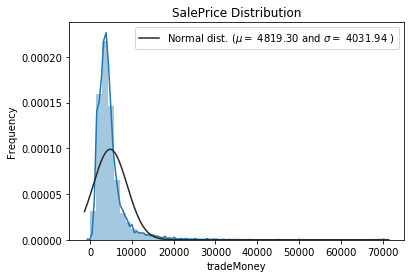

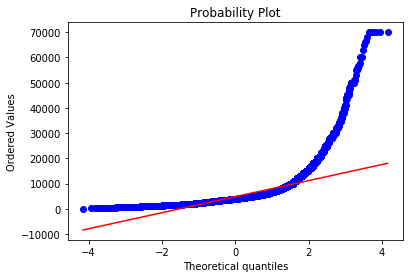

In [39]:
plot_dist_norm(target, 'SalePrice Distribution')

In [40]:
from scipy.special import boxcox1p #for Box Cox transformation

Text(0.5,1,'Skewness by feature')

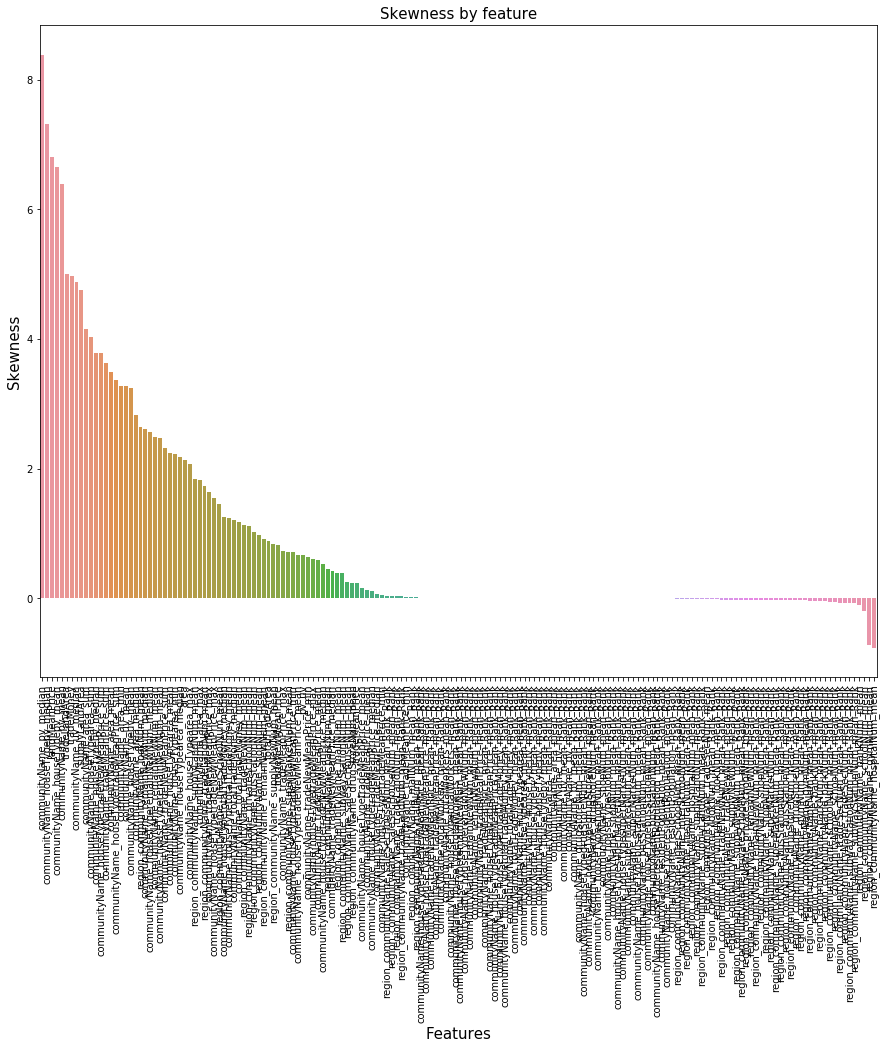

In [41]:

skewed_feats = all_data[all_data.dtypes[all_data.dtypes == "float64"].index].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=skewed_feats.index, y=skewed_feats)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Skewness', fontsize=15)
plt.title('Skewness by feature', fontsize=15)

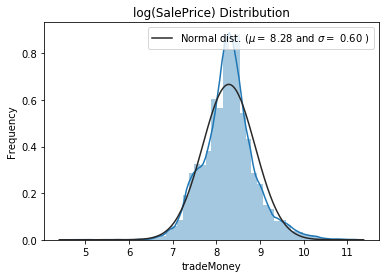

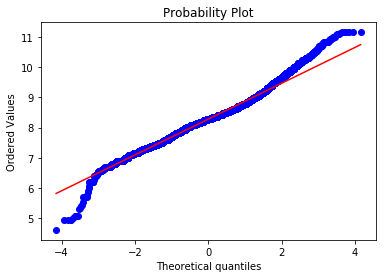

In [42]:
transform_log = np.log1p(target)
new_target = np.log1p(target)
plot_dist_norm(transform_log, 'log(SalePrice) Distribution') 

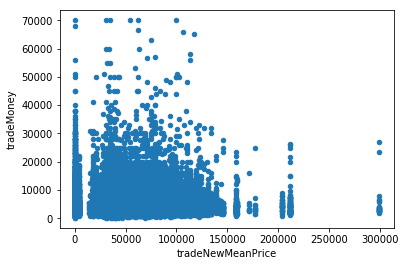

In [43]:
var = 'tradeNewMeanPrice'
data = pd.concat([target, train[var]], axis=1)
data.plot.scatter(x=var, y='tradeMoney')

In [44]:
community_fea = ['area','pv','uv','busStationNum','drugStoreNum', 'shopNum', 'superMarketNum',
       'totalTradeMoney', 'tradeMeanPrice', 'tradeNewMeanPrice',
       'remainNewNum', 'totalWorkers', 'residentPopulation']

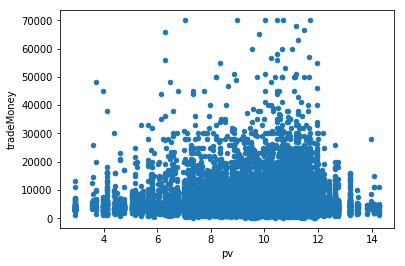

In [45]:
var = 'pv'
data = pd.concat([target, boxcox1p(train[var],0.01)], axis=1)
data.plot.scatter(x=var, y='tradeMoney')

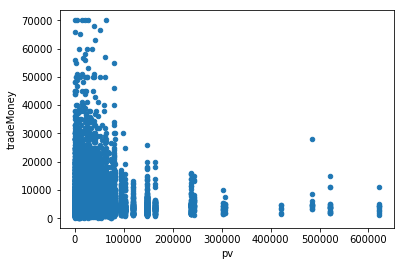

In [46]:
var = 'pv'
data = pd.concat([target, train[var]], axis=1)
data.plot.scatter(x=var, y='tradeMoney')

In [47]:
stats = []
for col in train.columns:
    stats.append((col, train[col].nunique(), train[col].isnull().sum() * 100 / train.shape[0], train[col].value_counts(normalize=True, dropna=False).values[0] * 100, train[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)[:10]

Feature  Unique_values  \
0                                                  ID          41391   
290  communityName_houseTyperesidentPopulation_median             63   
264        communityName_houseTypetotalTradeMoney_sum           6195   
263       communityName_houseTypetotalTradeMoney_mean           5832   
262        communityName_houseTypetotalTradeMoney_max            689   
261        communityName_houseTypetotalTradeMoney_min            696   
260      communityName_houseTypesuperMarketNum_median             49   
259         communityName_houseTypesuperMarketNum_sum            706   
258        communityName_houseTypesuperMarketNum_mean             49   
257         communityName_houseTypesuperMarketNum_max             49   

     Percentage of missing values  \
0                             0.0   
290                           0.0   
264                           0.0   
263                           0.0   
262                           0.0   
261                           0.0   
260                           0.0   
259                           0.0   
258                           0.0   
257                           0.0   

     Percentage of values in the biggest category     type  
0                                        0.002416    int64  
290                                      4.926192    int64  
264                                      0.959146    int64  
263                                      0.959146  float64  
262                                      3.365466    int64  
261                                      2.560943    int64  
260                                      7.653838    int64  
259                                      1.053369    int64  
258                                      7.653838    int64  
257                                      7.653838    int64

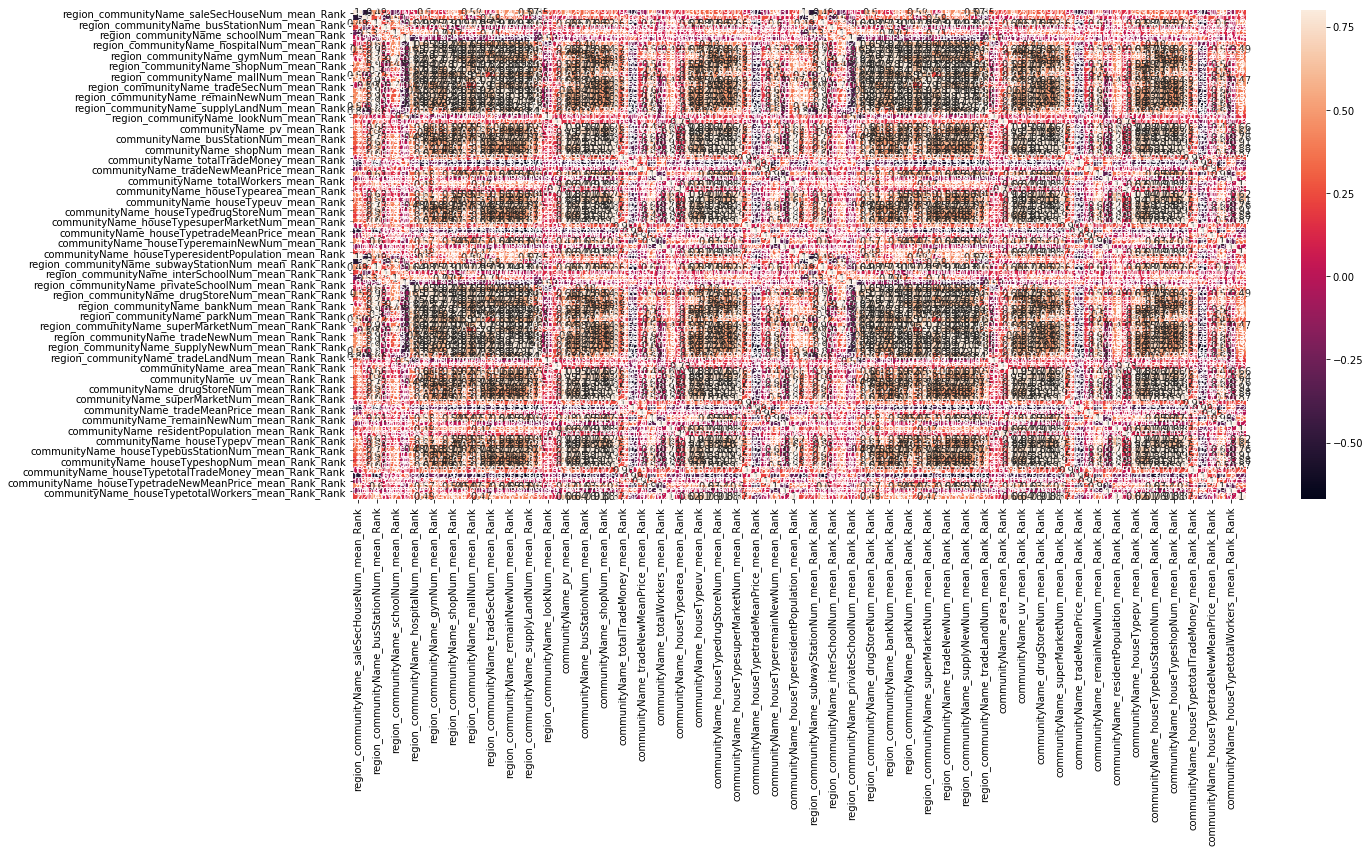

In [48]:
#correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns
cols = [col for col in all_data.columns if 'Rank' in col]
rank_data = train[cols]
corrmat = rank_data.corr()
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corrmat, vmax=.8, annot=True);

In [49]:
train.dtypes

ID                                                             int64
area                                                         float64
rentType                                                    category
room                                                           int64
big_room                                                       int64
wc                                                             int64
houseType                                                   category
houseFloor                                                  category
totalFloor                                                     int64
houseToward                                                 category
houseDecoration                                             category
communityName                                               category
region                                                      category
plate                                                       category
buildYear                         

In [50]:
params = {
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'min_child_samples':20,
    'objective': 'regression',
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "feature_fraction": 0.8,
    "bagging_freq": 1,
    "bagging_fraction": 0.85,
    "bagging_seed": 23,
    "metric": 'rmse',
    "lambda_l1": 0.2,
    "nthread": 4,
}
param = {'num_leaves': 120,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}

In [51]:
train=train.drop(['tradeMoney','tradeTime'],axis=1) #利用drop方法将含有特定数值的列删除

In [53]:
ID = train['ID']

In [52]:
test=test.drop(['tradeMoney','tradeTime'],axis=1) #利用drop方法将含有特定数值的列删除

In [54]:
test=test.drop(['ID'],axis=1) 

In [55]:
folds = KFold(n_splits=5, shuffle=True, random_state=2333)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance_df = pd.DataFrame()
#target=new_target.copy()
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold {}".format(fold_))
    
    tag_name = ['communityName','plate','region','ID']
    train['tradeMoney']=target
    train['ID']=ID
    train_csv = train.iloc[trn_idx]
    val_csv = train.iloc[val_idx]
    for tag in tag_name:
        for op in ['mean','std']:
            col_name =tag+'_'+op
            tmp = train_csv.groupby(tag)['tradeMoney'].agg(op)

            train_csv[col_name] = train_csv['communityName'].map(tmp)
            val_csv[col_name] = val_csv['communityName'].map(tmp)
            test[col_name] = test['communityName'].map(tmp)
    train_csv=train_csv.drop(['tradeMoney','ID'],axis=1) #利用drop方法将含有特定数值的列删除
    val_csv=val_csv.drop(['tradeMoney','ID'],axis=1) #利用drop方法将含有特定数值的列删除
    trn_data = lgb.Dataset(train_csv, label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(val_csv, label=target.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 200)
    
    oof_lgb[val_idx] = clf.predict(val_csv, num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = train_csv.columns.values
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_lgb += clf.predict(test, num_iteration=clf.best_iteration) / folds.n_splits
    
print("CV Score: {:<8.5f}".format(r2_score(target, oof_lgb)))

fold 0


/home/asus/.conda/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/asus/.conda/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/asus/.conda/envs/dl/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/asus/.conda/envs/dl/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in

Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1083.72	valid_1's rmse: 1441.27
[1000]	training's rmse: 915.62	valid_1's rmse: 1413.68
[1500]	training's rmse: 825.473	valid_1's rmse: 1405.97
[2000]	training's rmse: 764.431	valid_1's rmse: 1401.22
[2500]	training's rmse: 718.616	valid_1's rmse: 1399.64
Early stopping, best iteration is:
[2660]	training's rmse: 706.218	valid_1's rmse: 1398.92
fold 1


/home/asus/.conda/envs/dl/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/asus/.conda/envs/dl/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1116.4	valid_1's rmse: 1264.63
[1000]	training's rmse: 948.321	valid_1's rmse: 1216.78
[1500]	training's rmse: 857.047	valid_1's rmse: 1205.99
[2000]	training's rmse: 794.329	valid_1's rmse: 1200.54
[2500]	training's rmse: 747.149	valid_1's rmse: 1199.01
Early stopping, best iteration is:
[2781]	training's rmse: 725.903	valid_1's rmse: 1197.88
fold 2


/home/asus/.conda/envs/dl/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/asus/.conda/envs/dl/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1089.74	valid_1's rmse: 1355.93
Early stopping, best iteration is:
[690]	training's rmse: 1008.57	valid_1's rmse: 1347.34
fold 3


/home/asus/.conda/envs/dl/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/asus/.conda/envs/dl/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1087.77	valid_1's rmse: 1442.3
[1000]	training's rmse: 922.939	valid_1's rmse: 1401.34
[1500]	training's rmse: 834.186	valid_1's rmse: 1391.17
[2000]	training's rmse: 774.862	valid_1's rmse: 1390.73
Early stopping, best iteration is:
[1916]	training's rmse: 783.375	valid_1's rmse: 1389.77
fold 4


/home/asus/.conda/envs/dl/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/asus/.conda/envs/dl/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1053.11	valid_1's rmse: 1506.88
[1000]	training's rmse: 885.972	valid_1's rmse: 1474.51
[1500]	training's rmse: 798.751	valid_1's rmse: 1463.77
[2000]	training's rmse: 739.755	valid_1's rmse: 1460.38
[2500]	training's rmse: 696.596	valid_1's rmse: 1458.54
Early stopping, best iteration is:
[2398]	training's rmse: 704.513	valid_1's rmse: 1458.48
CV Score: 0.88600 


In [ ]:
sorted(predictions_lgb)

# 特征贡献值

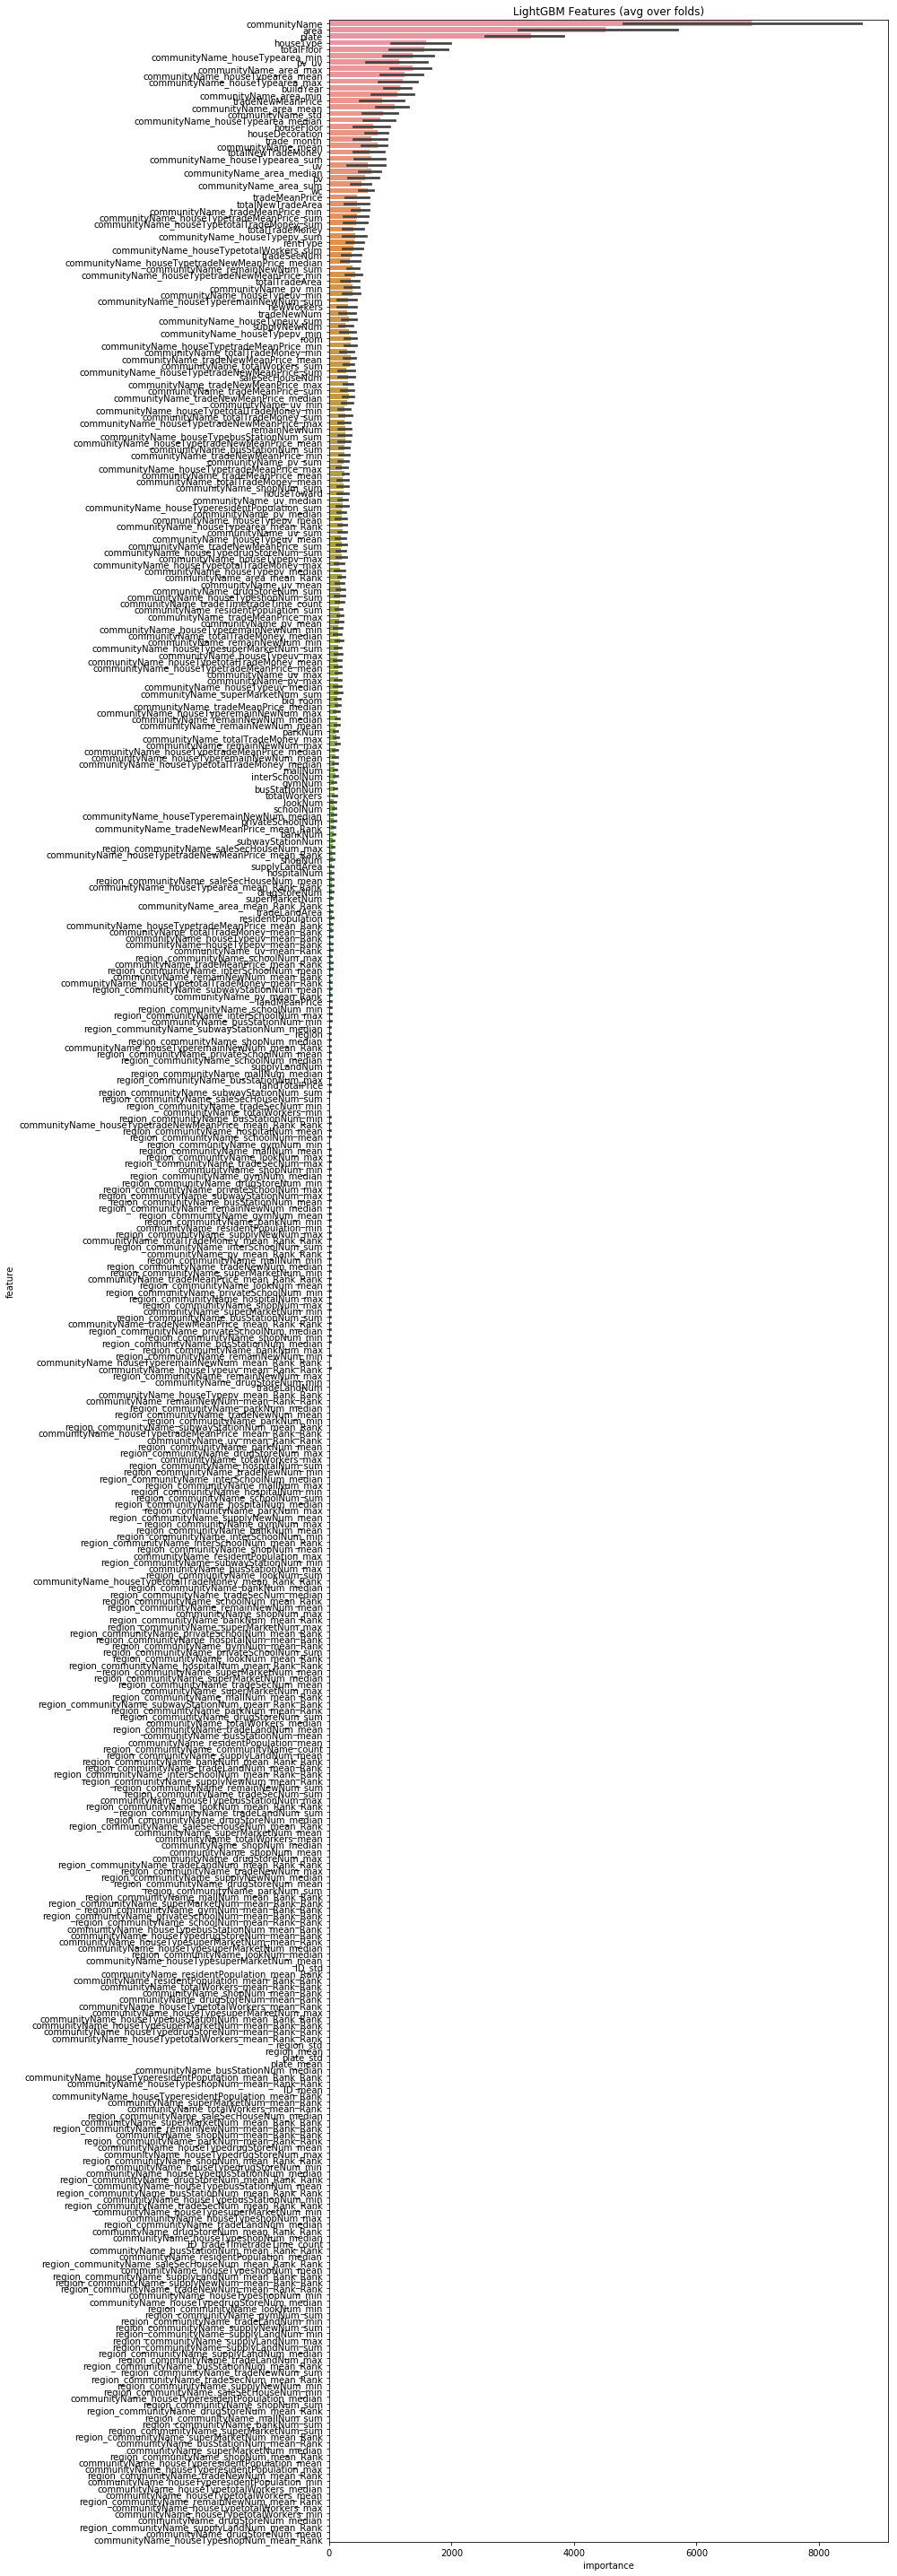

In [56]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,40))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [ ]:
imp_csv =best_features.sort_values(by="importance",ascending=False)

In [ ]:
imp_csv.columns

In [ ]:
imp_csv.iloc[236]

In [ ]:
imp_fea =[]
for idx in range(len(imp_csv)):

    col = imp_csv.iloc[idx]['feature']
    wgt = imp_csv.iloc[idx]['importance']
    if np.mean(wgt)>5:
        
        if col not in imp_fea:
            imp_fea.append(col)

In [ ]:
len(imp_fea),len(train.columns)

In [ ]:
folds = KFold(n_splits=5, shuffle=True, random_state=2333)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance_df = pd.DataFrame()
#target=new_target.copy()
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold {}".format(fold_))
    
 #   tag_name = 'communityName'
 #   train['tradeMoney']=target
    train_csv = train.iloc[trn_idx][imp_fea]
    val_csv = train.iloc[val_idx][imp_fea]
#     for op in ['mean','std']:
#         col_name =tag_name+'_'+op
#         tmp = train_csv.groupby(tag_name)['tradeMoney'].agg(op)

#         train_csv[col_name] = train_csv['communityName'].map(tmp)
#         val_csv[col_name] = val_csv['communityName'].map(tmp)
#         test[col_name] = test['communityName'].map(tmp)
 #   train_csv=train_csv.drop(['tradeMoney'],axis=1) #利用drop方法将含有特定数值的列删除
  #  val_csv=val_csv.drop(['tradeMoney'],axis=1) #利用drop方法将含有特定数值的列删除
    trn_data = lgb.Dataset(train_csv, label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(val_csv, label=target.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 200)
    
    oof_lgb[val_idx] = clf.predict(val_csv, num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = imp_fea
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_lgb += clf.predict(test[imp_fea], num_iteration=clf.best_iteration) / folds.n_splits
    
print("CV Score: {:<8.5f}".format(r2_score(target, oof_lgb)))

In [ ]:

column_importance = pd.DataFrame({'fea':list(train_x.columns),'imp':lgb_model.feature_importances_})
remove_col =[]
for idx in range(len(column_importance)):
    col = column_importance['fea'][idx]
    if col =='UID':
        continue
    wgt = column_importance['imp'][idx]
    if wgt<=1:
        if col in train_x.columns:
            remove_col.append(col)
        
            train_x = train_x.drop(col,axis=1)
            testB_x = testB_x.drop(col,axis=1)
print(train_x.shape),print(testB_x.shape)

# 生成提交数据

In [57]:
pd.DataFrame(predictions_lgb).apply(round).to_csv('submit.csv',na_rep='\n',index=False,encoding='utf8',header=False)